## Библиотеки

In [1]:
! git clone https://github.com/facebookresearch/fastText.git
! pip3 install fastText/.

Cloning into 'fastText'...
remote: Enumerating objects: 3930, done.
remote: Counting objects: 100% (964/964), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 3930 (delta 873), reused 825 (delta 825), pack-reused 2966
Receiving objects: 100% (3930/3930), 8.24 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (2505/2505), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./fastText
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4381799 sha256=f970f4215bc131e52a8afa20d712443a47b03ad6c6f96eb4622e96969b018f7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ot57rpxd/wheels/2d/3b/6c/b1dab8ae56dbff3fc7c26103ce1f0646f1a39f6a06db46db46
Successfully built fasttext


In [2]:
! pip install fasttext --quiet
! gdown --id 1su3IYY1avcj95tez69JI8f5qsTng72-I

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1su3IYY1avcj95tez69JI8f5qsTng72-I
To: /content/rudrec_fasttext_model.bin
100% 2.05G/2.05G [00:20<00:00, 98.2MB/s]


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.0 MB/s eta 0:00:00


In [4]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 75.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=a033a3a6d100d5165b200798e8b7bf6da51647551b1f503ecc090b6273c2a5d9
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [5]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.1 MB/s eta 0:00:00


In [6]:
import fasttext

import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import Text

import pymorphy2

from keras_preprocessing import sequence
from keras_preprocessing.text import Tokenizer

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow import keras
from tensorflow.keras import  Sequential, layers

import torch
from torch import nn, optim
#from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, Trainer, TrainingArguments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
import pandas as pd
import numpy as np
import math
from itertools import *

import time
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go

#import json
#from google.colab import drive

import re
from warnings import filterwarnings
filterwarnings('ignore')

## Данные

### traint.csv

In [131]:
df_train = pd.read_csv('train.csv').rename(columns={"Unnamed: 0": "id"})

print('Shape: ', df_train.shape)

print(pd.unique(df_train['sentiment']))
print(pd.unique(df_train['1category']))

Shape:  (19361, 5)
['+' '−' '?']
['Communication' '?' 'Quality' 'Price' 'Safety']


In [132]:
df_train.head()

,id,sentence,1category,2category,sentiment
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+


### test

In [138]:
df_test = pd.read_csv('1sentencenewtest.csv').rename(columns={"0": "texts"})
print('Shape: ', df_test.shape)

Shape:  (949, 2)


In [139]:
df_test.head(5)

,Unnamed: 0,texts
0,0,15.03.2022 обратился на горячую линию для закр...
1,1,"Уже который год в ТКБ не решается ""глобальная ..."
2,2,Добрый день
3,3,"Добрый день Сегодня, зайдя в свой личный кабин..."
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес..."


In [140]:
df_ex = pd.read_csv('sub_example_true.csv')
df_ex.head(5)

,Unnamed: 0,texts,+,-,?,communication,quality,price,safety,second_category
0,186,Хочу сказать огромное спасибо банку Тинькофф з...,0.33,0.33,0.33,0.25,0.25,0.25,0.25,0
1,7722,"Альфа-банк, привет! Хотел узнать, что надо так...",0.33,0.33,0.33,0.25,0.25,0.25,0.25,1
2,4580,Являюсь клиентом данного банка уже более 10 ле...,0.33,0.33,0.33,0.25,0.25,0.25,0.25,1
3,1982,Часть 1. Отзыв пришлось разделить на 2 части и...,0.33,0.33,0.33,0.25,0.25,0.25,0.25,0
4,864,Здравствуйте. Хочу поделиться очень грустной и...,0.33,0.33,0.33,0.25,0.25,0.25,0.25,0


## Предобработка

In [141]:
russian_stopwords = stopwords.words("russian") + ['это']
left_ = ['не', 'нет', 'нельзя', 'даже', 'почти', 'наконец', 'много', 'вcегда', 'более', 'лучше', 'хорошо']
morph = pymorphy2.MorphAnalyzer()

def clean(text):
    # приводим к нижнему регистру и разбиваем на токены
    tokens = word_tokenize(text.lower())
    # приводим токены к начальной форме
    for i in range (len(tokens)):
            tokens[i] = morph.parse(tokens[i])[0].normal_form
    # удаляем стоп-слова
    tokens = [token for token in tokens if ((token not in russian_stopwords) or (token in left_))]
    # убираем все, что не слова/?/!/""
    tokens =  [token for token in tokens if token.isalpha() or token in ['!','?', '"']]
    # считаем кол-во токенов после очистки/не/?/!/"
    #cur_len = len(tokens)
    text = " ".join(tokens)
    return text #, cur_len

def clean_texts(texts):
    cleaned_txt = [clean(t) for t in texts.values]
    return cleaned_txt

In [142]:
df_train['cleaned'] = clean_texts(df_train['sentence'])

In [150]:
df_test['cleaned'] = clean_texts(df_test['texts'])

In [143]:
df_train['length'] = df_train['cleaned'].apply(lambda x: len(x.split()))

df_train['with not'] = df_train['cleaned'].apply(lambda x: 0 if x.count('не') + x.count('нет') == 0 else 1)
df_train['with ? or !'] = df_train['cleaned'].apply(lambda x: 0 if x.count('?') == 0 and x.count('!') == 0 else 1)
df_train['with "'] = df_train['sentence'].apply(lambda x: 0 if x.count('"') == 0 else 1)

In [144]:
df_train.head(5)

,id,sentence,1category,2category,sentiment,cleaned,length,with not,with ? or !,"with """
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+,получать качественный услуга,3,0,0,0
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−,не видеть хотя поставить сервис !,6,1,1,0
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−,любимый банк мкб обмануть,4,0,0,1
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−,отвратительный отношение клиент,3,0,0,0
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+,любой время день ночь помочь ответить решить,7,0,0,0


In [145]:
df_train.to_csv('df_train_cleaned.csv')

In [146]:
print(max(df_train.length))

108


In [147]:
text_tokens = str()
for txt in df_train['cleaned'].values:
    text_tokens += txt
text_tokens = text_tokens.split()
text = Text(text_tokens)
fdist = FreqDist(text)

print(len(fdist))

21331


In [148]:
print(fdist.most_common(25))

[('не', 8264), ('банк', 5940), ('!', 2477), ('всё', 2353), ('сотрудник', 2228), ('клиент', 1948), ('карта', 1904), ('который', 1878), ('свой', 1432), ('очень', 1339), ('мочь', 1251), ('отделение', 1227), ('работа', 1084), ('вопрос', 1002), ('весь', 979), ('ещё', 946), ('просто', 910), ('деньга', 895), ('день', 873), ('работать', 823), ('обслуживание', 750), ('отношение', 738), ('офис', 729), ('время', 714), ('год', 713)]


In [151]:
df_test.head(10)

,Unnamed: 0,texts,cleaned
0,0,15.03.2022 обратился на горячую линию для закр...,обратиться горячий линия закрытие счёт кредит ...
1,1,"Уже который год в ТКБ не решается ""глобальная ...",который год ткб не решаться глобальный проблем...
2,2,Добрый день,добрый день
3,3,"Добрый день Сегодня, зайдя в свой личный кабин...",добрый день сегодня зайти свой личный кабинет ...
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес...",обслуживаться тинькофф пара год возникнуть жес...
5,5,"В начале месяца прогремела новость о том, что ...",начало месяц прогреметь новость начинать июнь ...
6,6,Оставляю отзыв о работе персонального менеджер...,оставлять отзыв работа персональный никита
7,7,После введенных ЦБ ограничений выдача наличных...,ввести цб ограничение выдача наличный доллар о...
8,8,"Захожу на сайт ВТБ, вхожу в личный кабинет, но...",заходить сайт втб входить личный кабинет не мо...
9,9,Банк замечательно и быстро выдает кредит- тут ...,банк замечательный быстро выдавать всё наладит...


## Анализ данных


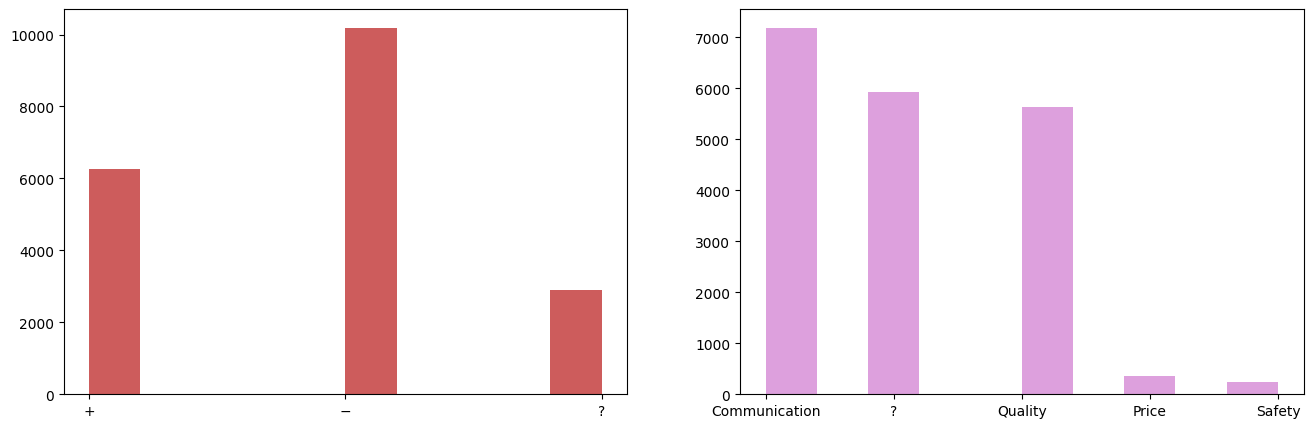

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
axs[0].hist(df_train['sentiment'], color = 'indianred')
#axs[0].set_title('Индикатор типа конвергенции', fontsize=10)
axs[1].hist(df_train['1category'], color = 'plum')
#axs[1].set_title('Распределение мнений', fontsize=10)
plt.show()

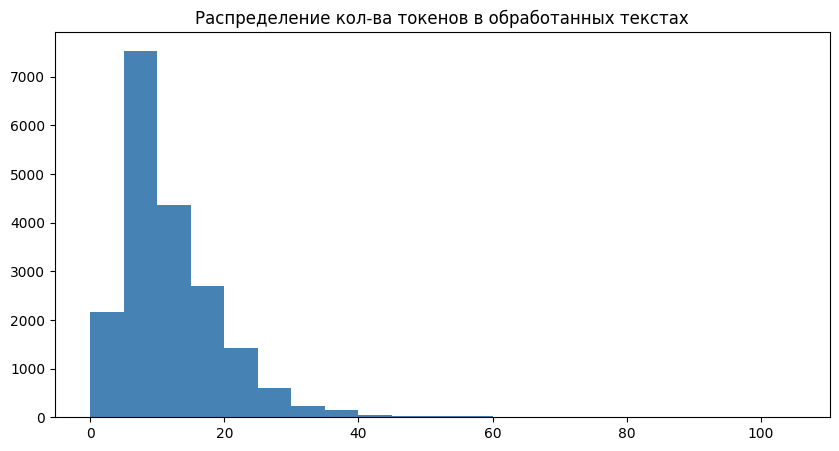

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.hist(df_train['length'], bins=np.arange(0, 110, 5), color = 'steelblue')
plt.title("Распределение кол-ва токенов в обработанных текстах", fontsize=12)
plt.show()

In [ ]:
# визуализация по кластерам
# визуализация по not/?/!/""

## Разбиение выборки

In [152]:
train_df, valid_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['sentiment'])

train_texts = train_df['cleaned'].values
valid_texts = valid_df['cleaned'].values

train_labels = train_df['sentiment'].values
valid_labels = valid_df['sentiment'].values

In [153]:
print('Train', len(train_df))
print(train_df.groupby(['sentiment']).count()[['id']], '\n')

print('Validation', len(valid_df))
print(valid_df.groupby(['sentiment']).count()[['id']], '\n')

Train 15488
             id
sentiment      
+          5009
?          2326
−          8153 

Validation 3873
             id
sentiment      
+          1253
?           581
−          2039 



## Модель

**CNN**\
https://www.embedded-robotics.com/cnn-for-multi-label-text-classification/

### Sentiment

In [154]:
def get_lab(x):
    if x == '−':
        return 0
    elif x == '?':
        return 1
    elif x == '+':
        return 2

train_labels_ = train_df['sentiment'].apply(lambda x: get_lab(x)).values
valid_labels_ = valid_df['sentiment'].apply(lambda x: get_lab(x)).values

In [155]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

word_index = tokenizer.word_index
dictionary_size = len(word_index.keys()) + 1

In [156]:
train_to_seq = tokenizer.texts_to_sequences(train_texts)
valid_to_seq = tokenizer.texts_to_sequences(valid_texts)

In [157]:
max_len = max(train_df['length'].values)

train_seq_pad = sequence.pad_sequences(train_to_seq, maxlen=max_len)
valid_seq_pad = sequence.pad_sequences(valid_to_seq, maxlen=max_len)

In [158]:
test_texts = df_test['cleaned'].values
test_to_seq = tokenizer.texts_to_sequences(test_texts)
test_seq_pad = sequence.pad_sequences(test_to_seq, maxlen=max_len)

In [159]:
emb_size=200

fasttext_model = fasttext.load_model('rudrec_fasttext_model.bin')

embedding_matrix = np.zeros((dictionary_size, emb_size))

for word, i in word_index.items():
    embedding_vector = fasttext_model.get_word_vector((word))
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector

#### Основная попытка

In [160]:
class CNN_for_text(Model):

    def __init__(self, maxlen, max_features, 
                 embedding_dims, embedding_weights,
                 kernel_sizes=[3, 4, 5], 
                 class_num=1, last_activation='sigmoid',):
        super(CNN_for_text, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.kernel_sizes = kernel_sizes
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen, weights=[embedding_weights], )
        self.convs = []
        self.max_poolings = []
        for kernel_size in self.kernel_sizes:
            self.convs.append(Conv1D(128, kernel_size, activation='relu'))
            self.max_poolings.append(GlobalMaxPooling1D())
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        embedding = self.embedding(inputs)
        convs = []
        for i in range(len(self.kernel_sizes)):
            c = self.convs[i](embedding)
            c = self.max_poolings[i](c)
            convs.append(c)
        x = Concatenate()(convs)
        output = self.classifier(x)
        return output

In [161]:
model = CNN_for_text(maxlen=max_len, max_features=dictionary_size, 
                embedding_dims=emb_size, embedding_weights=embedding_matrix, 
                class_num=3, last_activation='softmax')

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5 , mode='max', restore_best_weights=True)

model_hist = model.fit(train_seq_pad, train_labels_,
        batch_size=128,
        epochs=10,
        callbacks=[early_stopping, ],
        validation_data=(valid_seq_pad, valid_labels_))

Epoch 1/10
121/121 [==============================] - 105s 861ms/step - loss: 0.5261 - accuracy: 0.7993 - val_loss: 0.4227 - val_accuracy: 0.8433
Epoch 2/10
121/121 [==============================] - 104s 859ms/step - loss: 0.3039 - accuracy: 0.8936 - val_loss: 0.3700 - val_accuracy: 0.8763
Epoch 3/10
121/121 [==============================] - 137s 1s/step - loss: 0.2338 - accuracy: 0.9112 - val_loss: 0.3852 - val_accuracy: 0.8704
Epoch 4/10
121/121 [==============================] - 115s 957ms/step - loss: 0.2107 - accuracy: 0.9150 - val_loss: 0.3920 - val_accuracy: 0.8768
Epoch 5/10
121/121 [==============================] - 108s 884ms/step - loss: 0.1990 - accuracy: 0.9154 - val_loss: 0.4002 - val_accuracy: 0.8750
Epoch 6/10
121/121 [==============================] - 113s 930ms/step - loss: 0.1889 - accuracy: 0.9130 - val_loss: 0.4201 - val_accuracy: 0.8704
Epoch 7/10
121/121 [==============================] - 110s 914ms/step - loss: 0.1858 - accuracy: 0.9143 - val_loss: 0.4267 - va

In [162]:
predicted_valid_prob = model.predict(valid_seq_pad)

valid_df['prob_neg'] = predicted_valid_prob[:, 0]
valid_df['prob_neutr'] = predicted_valid_prob[:, 1]
valid_df['prob_pos'] = predicted_valid_prob[:, 2]

122/122 [==============================] - 9s 73ms/step


In [163]:
valid_df[['sentence', 'sentiment', 'prob_neg', 'prob_neutr', 'prob_pos']].head(10)

,sentence,sentiment,prob_neg,prob_neutr,prob_pos
9697,"Помимо того, что слетела возможность входить в...",−,0.993677,0.003418,0.002904
656,"Бывает и такое, дебетовую уже терял, поэтому з...",−,0.997930,0.001714,0.000356
7688,Очень доволен такой оперативностью.,+,0.000148,0.014784,0.985068
2779,!вообще не занимаются такими вопросами!,?,0.931112,0.061276,0.007612
18004,Спасибо Сберу за качество обслуживание клиента.,+,0.027006,0.004954,0.968040
7768,"Мне сказали, что ""обращения в электронном виде...",−,0.993124,0.005797,0.001079
15899,"За профессионализм, терпение, инициативность, ...",+,0.002036,0.001957,0.996007
6443,Но к сожалению в банке отказали и не приняли д...,−,0.863371,0.134696,0.001933
14854,Служба поддержки клиентов МТС Банка даже не вн...,−,0.945329,0.024240,0.030431
9715,Пользуюсь расчетной картой банка для обмена ва...,+,0.015141,0.052951,0.931908


In [164]:
roc_auc_neg = roc_auc_score(valid_df['sentiment'].apply(lambda x: 1 if x == '−' else 0).values, valid_df['prob_neg'])
roc_auc_neutr = roc_auc_score(valid_df['sentiment'].apply(lambda x: 1 if x == '?' else 0).values, valid_df['prob_neutr'])
roc_auc_pos = roc_auc_score(valid_df['sentiment'].apply(lambda x: 1 if x == '+' else 0).values, valid_df['prob_pos'])

print(f'ROC-AUC for negative = {round(roc_auc_neg, 5)}')
print(f'ROC-AUC for neutral = {round(roc_auc_neutr, 5)}')
print(f'ROC-AUC for positive = {round(roc_auc_pos, 5)}', '\n')

roc_auc_all = roc_auc_score(valid_labels_, predicted_valid_prob, multi_class='ovr')
print(f'ROC-AUC по 3 классам = {round(roc_auc_all, 5)}')

ROC-AUC for negative = 0.97077
ROC-AUC for neutral = 0.89193
ROC-AUC for positive = 0.9729 

ROC-AUC по 3 классам = 0.9452


In [165]:
predicted_test_prob = model.predict(test_seq_pad)

df_test['prob_neg'] = predicted_test_prob[:, 0]
df_test['prob_neutr'] = predicted_test_prob[:, 1]
df_test['prob_pos'] = predicted_test_prob[:, 2]

30/30 [==============================] - 3s 105ms/step


In [166]:
df_test.head(10)

,Unnamed: 0,texts,cleaned,prob_neg,prob_neutr,prob_pos
0,0,15.03.2022 обратился на горячую линию для закр...,обратиться горячий линия закрытие счёт кредит ...,0.566648,0.219906,0.213446
1,1,"Уже который год в ТКБ не решается ""глобальная ...",который год ткб не решаться глобальный проблем...,0.647769,0.118315,0.233916
2,2,Добрый день,добрый день,0.028058,0.889592,0.082350
3,3,"Добрый день Сегодня, зайдя в свой личный кабин...",добрый день сегодня зайти свой личный кабинет ...,0.963467,0.031782,0.004751
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес...",обслуживаться тинькофф пара год возникнуть жес...,0.001652,0.032604,0.965743
5,5,"В начале месяца прогремела новость о том, что ...",начало месяц прогреметь новость начинать июнь ...,0.628395,0.336369,0.035236
6,6,Оставляю отзыв о работе персонального менеджер...,оставлять отзыв работа персональный никита,0.335195,0.099893,0.564912
7,7,После введенных ЦБ ограничений выдача наличных...,ввести цб ограничение выдача наличный доллар о...,0.602366,0.365828,0.031806
8,8,"Захожу на сайт ВТБ, вхожу в личный кабинет, но...",заходить сайт втб входить личный кабинет не мо...,0.935252,0.056716,0.008032
9,9,Банк замечательно и быстро выдает кредит- тут ...,банк замечательный быстро выдавать всё наладит...,0.374629,0.156447,0.468924


In [167]:
df_test_final = pd.DataFrame(columns = df_ex.columns)
df_test_final['Unnamed: 0'] = df_test['Unnamed: 0']
df_test_final['texts'] = df_test['texts']
df_test_final["+"] = df_test['prob_pos']
df_test_final["-"] = df_test['prob_neg']
df_test_final["?"] = df_test['prob_neutr']

print(df_test_final.head(5))

df_test_final.to_csv('test_FINAL.csv')

   Unnamed: 0                                              texts         +  \
0           0  15.03.2022 обратился на горячую линию для закр...  0.213446   
1           1  Уже который год в ТКБ не решается "глобальная ...  0.233916   
2           2                                        Добрый день  0.082350   
3           3  Добрый день Сегодня, зайдя в свой личный кабин...  0.004751   
4           4  Обслуживаюсь в Тинькофф пару лет, возникла жес...  0.965743   

          -         ? communication quality price safety second_category  
0  0.566648  0.219906           NaN     NaN   NaN    NaN             NaN  
1  0.647769  0.118315           NaN     NaN   NaN    NaN             NaN  
2  0.028058  0.889592           NaN     NaN   NaN    NaN             NaN  
3  0.963467  0.031782           NaN     NaN   NaN    NaN             NaN  
4  0.001652  0.032604           NaN     NaN   NaN    NaN             NaN  


### Категории

In [97]:
df_train_cat = pd.read_csv('df_train_cleaned.csv')
df_train_cat = df_train_cat[df_train_cat['1category'] != '?'] # удаляем непонятную категорию

In [98]:
def get_lab_cat(x):
    if x == 'Communication':
        return 0
    elif x == 'Quality':
        return 1
    elif x == 'Price':
        return 2
    elif x == 'Safety':
        return 3

train_df_cat, valid_df_cat = train_test_split(df_train_cat, test_size=0.15, random_state=42, stratify=df_train_cat['1category'])

train_texts_ = train_df_cat['cleaned'].values
valid_texts_ = valid_df_cat['cleaned'].values

train_labels_cat = train_df_cat['1category'].apply(lambda x: get_lab_cat(x)).values
valid_labels_cat = valid_df_cat['1category'].apply(lambda x: get_lab_cat(x)).values

In [ ]:
test_texts_ = df_test['cleaned'].values

In [115]:
tokenizer_cat = Tokenizer()
tokenizer_cat.fit_on_texts(train_texts_)

word_index_c = tokenizer_cat.word_index
dictionary_size_c = len(word_index_c.keys()) + 1

train_to_seq_c = tokenizer_cat.texts_to_sequences(train_texts_)
valid_to_seq_c = tokenizer_cat.texts_to_sequences(valid_texts_)

max_len_c = max(train_df_cat['length'].values)
train_seq_pad_c = sequence.pad_sequences(train_to_seq_c, maxlen=max_len_c)
valid_seq_pad_c= sequence.pad_sequences(valid_to_seq_c, maxlen=max_len_c)

In [116]:
fasttext_model = fasttext.load_model('rudrec_fasttext_model.bin')

embedding_matrix_cat = np.zeros((dictionary_size_c, emb_size))

for word, i in word_index_c.items():
    embedding_vector = fasttext_model.get_word_vector((word))
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix_cat[i] = embedding_vector

In [118]:
model_cat = CNN_for_text(maxlen=max_len_c, max_features=dictionary_size_c, 
                embedding_dims=emb_size, embedding_weights=embedding_matrix_cat, 
                class_num=4, last_activation='softmax')

model_cat.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5 , mode='max', restore_best_weights=True)

model_hist_cat = model_cat.fit(train_seq_pad_c, train_labels_cat,
        batch_size=128,
        epochs=10,
        callbacks=[early_stopping, ],
        validation_data=(valid_seq_pad_c, valid_labels_cat))

Epoch 1/10
90/90 [==============================] - 75s 810ms/step - loss: 0.7546 - accuracy: 0.6655 - val_loss: 0.6454 - val_accuracy: 0.7103
Epoch 2/10
90/90 [==============================] - 74s 826ms/step - loss: 0.5357 - accuracy: 0.7659 - val_loss: 0.6450 - val_accuracy: 0.7044
Epoch 3/10
90/90 [==============================] - 72s 803ms/step - loss: 0.4581 - accuracy: 0.7925 - val_loss: 0.7064 - val_accuracy: 0.6801
Epoch 4/10
90/90 [==============================] - 75s 839ms/step - loss: 0.4135 - accuracy: 0.8031 - val_loss: 0.7108 - val_accuracy: 0.6880
Epoch 5/10
90/90 [==============================] - 93s 1s/step - loss: 0.3859 - accuracy: 0.8121 - val_loss: 0.7747 - val_accuracy: 0.6820
Epoch 6/10
90/90 [==============================] - 73s 812ms/step - loss: 0.3765 - accuracy: 0.8122 - val_loss: 0.7941 - val_accuracy: 0.6875


In [119]:
predicted_valid_prob_cat = model_cat.predict(valid_seq_pad_c)

63/63 [==============================] - 3s 42ms/step


In [127]:
valid_df_cat['Communication_prob'] = predicted_valid_prob_cat[:, 0]
valid_df_cat['Quality_prob'] = predicted_valid_prob_cat[:, 1]
valid_df_cat['Price_prob'] = predicted_valid_prob_cat[:, 2]
valid_df_cat['Safety_prob'] = predicted_valid_prob_cat[:, 3]

In [129]:
valid_df_cat.head(10)

,Unnamed: 0,id,sentence,1category,2category,sentiment,cleaned,length,with not,with ? or !,"with """,Communication_prob,Quality_prob,Price_prob,Safety_prob
1145,1145,18160,"И это очень большая проблема, так как очень ча...",Quality,NaN,−,очень больший проблема очень часто деньга срок...,12,1,0,0,0.160987,0.735605,0.095225,0.008183
6549,6549,14844,"Так же, мы очень благодарны девочкам, особенно...",Quality,NaN,+,очень благодарный девочка особенно надежда вып...,13,0,0,0,0.404247,0.574684,0.013701,0.007368
6389,6389,5136,"Подали заявку в отделение 19.02.2021 , докумен...",Communication,NaN,+,подать заявка отделение документ принять сказа...,28,0,1,0,0.475089,0.504071,0.013901,0.006939
10858,10858,8484,Только стандартные отговорки что мы колл-центр...,Communication,NaN,−,стандартный отговорка не мочь колл центр ? ?,8,1,1,0,0.751570,0.223623,0.009782,0.015025
9411,9411,7974,"Когда это будет сделано... это не сервис, я об...",Communication,NaN,−,сделать не сервис обеспокоить возмутить сложит...,36,1,0,0,0.652574,0.325391,0.009767,0.012268
7877,7877,4984,После чего еще за 5 минут как то сразу всех бы...,Communication,NaN,+,ещё минута сразу весь быстро обслужить,6,0,0,0,0.284121,0.699574,0.011380,0.004926
2408,2408,4775,Всё необходимое я получил в полном объёме.,Communication,NaN,+,всё необходимый получить полный объём,5,1,0,0,0.403382,0.413279,0.163776,0.019563
10809,10809,7753,21.05.2020 позвонил сотрудник банка с номера 7...,Communication,NaN,−,позвонить сотрудник банк номер подтвердить спу...,13,0,1,0,0.878925,0.097905,0.004755,0.018415
2303,2303,17854,"Когда мне девушка ее дала, я немного обалдела ...",Quality,NaN,−,девушка дать немного обалдеть имя карта написа...,16,1,0,0,0.356387,0.583139,0.027712,0.032761
3697,3697,18074,"Остается только два вопроса, за что арестован ...",Quality,NaN,−,оставаться вопрос арестовать счёт согласно док...,14,0,1,0,0.245931,0.563259,0.137231,0.053579


In [130]:
roc_auc_all_cat = roc_auc_score(valid_labels_cat, predicted_valid_prob_cat, multi_class='ovr')
print(f'ROC-AUC по 4 классам = {round(roc_auc_all_cat, 5)}')

ROC-AUC по 4 классам = 0.86654


In [168]:
test_to_seq_c = tokenizer_cat.texts_to_sequences(test_texts)
test_seq_pad_c = sequence.pad_sequences(test_to_seq_c, maxlen=max_len_c)

In [169]:
predicted_test_prob_cat = model_cat.predict(test_seq_pad_c)

df_test_final["communication"] = predicted_test_prob_cat[:, 0]
df_test_final["quality"] = predicted_test_prob_cat[:, 1]
df_test_final["price"] = predicted_test_prob_cat[:, 2]
df_test_final["safety"] = predicted_test_prob_cat[:, 3]

30/30 [==============================] - 2s 68ms/step


In [170]:
df_test_final['second_category'] = [0]*df_test_final.shape[0]

In [171]:
df_test_final.head(5)

,Unnamed: 0,texts,+,-,?,communication,quality,price,safety,second_category
0,0,15.03.2022 обратился на горячую линию для закр...,0.213446,0.566648,0.219906,0.287134,0.412462,0.256388,0.044016,0
1,1,"Уже который год в ТКБ не решается ""глобальная ...",0.233916,0.647769,0.118315,0.173142,0.749694,0.059469,0.017695,0
2,2,Добрый день,0.082350,0.028058,0.889592,0.656087,0.248804,0.072850,0.022259,0
3,3,"Добрый день Сегодня, зайдя в свой личный кабин...",0.004751,0.963467,0.031782,0.630897,0.348531,0.014105,0.006468,0
4,4,"Обслуживаюсь в Тинькофф пару лет, возникла жес...",0.965743,0.001652,0.032604,0.213010,0.508669,0.265816,0.012505,0


In [172]:
df_test_final.to_csv('test_result.csv')